# Housing Prices in Ames, IA

In [50]:
#Let's import what we will need

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler

In [51]:
#Here are the data sets

houses = pd.read_csv('./data/train.csv')
holdout = pd.read_csv('./data/test.csv')

/Users/williammccarthy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


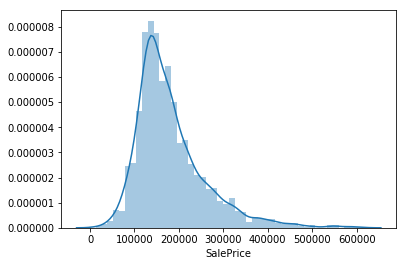

In [52]:
#Let's look at distribution of SalePrice
sns.distplot(houses['SalePrice'])

/Users/williammccarthy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Ln SalePrice')

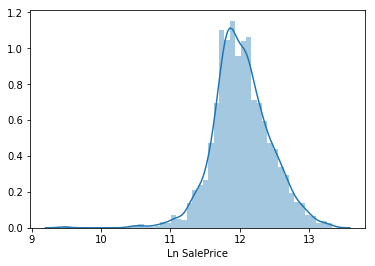

In [129]:
#It's skewed positively, so let's take the natural log of everything to make it more normal. 
#We will score against that to take care of outliers.

sns.distplot(np.log(houses['SalePrice']))
plt.xlabel("Ln SalePrice")

In [54]:
#Initial EDA
houses.info()
houses.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

(2051, 81)

#Will not run this as the output is long, but I used this to weed out any features that only applied to less than 15% of the dataset. If 85% or more of the dataset was of a specific value, I dropped the column. Additionally, if a column was covered by another, I dropped it (Finished + Unfinished SF = Total SF).

### for col in houses.select_dtypes(include = object):
   ### print(houses[col].value_counts())
    
PID: unknown, probably ID number

Street: only 7 houses are on gravel streets versus paved

Alley: 55 have paved alley, 85 have gravel alley, rest are NaN

Utilities: only 2 houses are not all public utilities

Land Slope: 1953 houses with gentle slop, only 98 with moderate or severe

Roof Matl: 2025 have CompShg rooves

Land contour: 1843 are level

Bsmt Cond: 1834 are typical

Heating: 2018 are GasA

Electrical: 1868 are SBrkr

Low Qual Fin SF: 2018 have 0

Kitchen AbvGr: 1960 only have one

1st/2nd floor SF: can be covered by total SF

Paved Drive: 1861 are paved

Central Air: 1910 have it

Functional: 1915 are typical

Pool Area/ Pool QC: 2042 do not have pools

Misc feature/ Misc Val: only 65 have something

BsmtFin SF 1, BsmtFin SF 2: Covered by total Bsmt

SaleType is unfair to use. It is implicated in the sale, and this is for predictions of the sale

In [55]:
#Here are the columns to drop
cols_to_drop = ['Street', 'Alley', 'Utilities', 'Land Slope', 
                'Land Contour', 'Roof Matl', 'Bsmt Cond', 
                'Heating', 'Low Qual Fin SF', 'Paved Drive', 
                'Central Air', 'Functional', 'Pool Area', 
                'Pool QC', 'Misc Feature', 'Misc Val',
                'PID', 'Kitchen AbvGr', '1st Flr SF', 'Electrical', 
                '2nd Flr SF', 'Sale Type', 'Bsmt Unf SF', 
                'Lot Frontage', 'MS Zoning', 'MS SubClass', 
                'Condition 1', 'Condition 2', 'Fireplace Qu',
                'BsmtFin Type 1', 'BsmtFin Type 2', 'BsmtFin SF 1', 
                'BsmtFin SF 2'
               ]
houses.drop(cols_to_drop, axis = 1, inplace = True)
holdout.drop(cols_to_drop, axis =1, inplace = True)

In [56]:
#Now we will change some categorical data to numeric based on a scale

ranked_categoricals = ['Kitchen Qual', 'Heating QC', 'Bsmt Qual', 
                       'Garage Qual', 'Garage Cond', 'Exter Qual', 'Exter Cond'
                      ]

houses[ranked_categoricals] = houses[ranked_categoricals].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5, 4, 3, 2, 1])
holdout[ranked_categoricals] = holdout[ranked_categoricals].replace(['Ex', 'Gd', 'TA', 'Fa', 'Po'], [5, 4, 3, 2, 1])

house_style_names = list(houses['House Style'].unique())
house_style_numbers = [2.0, 1.0, 1.5, 1.5, 1.5, 2.5, 2.5, 1.5]
houses['House Style'] = houses['House Style'].replace(house_style_names, house_style_numbers)
holdout['House Style'] = holdout['House Style'].replace(house_style_names, house_style_numbers)

In [57]:
#Now we engineer some features that have to do with the same thing
houses['Exterior Score'] = houses['Exter Cond'] * houses['Exter Qual']
holdout['Exterior Score'] = holdout['Exter Cond'] * holdout['Exter Qual']

houses['Garage Score'] = houses['Garage Cond'] * houses['Garage Qual']
holdout['Garage Score'] = holdout['Garage Cond'] * holdout['Garage Qual']

houses['Porch SF'] = houses['Wood Deck SF'] + houses['Open Porch SF'] + houses['Enclosed Porch'] + houses['3Ssn Porch'] + houses['Screen Porch']
holdout['Porch SF'] = holdout['Wood Deck SF'] + holdout['Open Porch SF'] + holdout['Enclosed Porch'] + holdout['3Ssn Porch'] + holdout['Screen Porch']

houses['Overall QualCond'] = houses['Overall Qual'] * houses['Overall Cond']
holdout['Overall QualCond'] = holdout['Overall Qual'] * holdout['Overall Cond']

houses['Bathrooms'] = houses['Full Bath'] + houses['Bsmt Full Bath'] + (houses['Half Bath'] + houses['Bsmt Half Bath'])/2
holdout['Bathrooms'] = holdout['Full Bath'] + holdout['Bsmt Full Bath'] + (holdout['Half Bath'] + holdout['Bsmt Half Bath'])/2


#And we drop the unnecessary columns
more_cols_to_drop = ['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 
                     '3Ssn Porch', 'Screen Porch', 'Overall Qual', 
                     'Overall Cond', 'Full Bath', 'Bsmt Full Bath', 
                     'Half Bath', 'Bsmt Half Bath', 'Garage Qual', 
                     'Garage Cond', 'Exter Qual', 'Exter Cond']

houses.drop(more_cols_to_drop, axis = 1, inplace = True)
holdout.drop(more_cols_to_drop, axis = 1, inplace = True)

In [58]:
#Now check out our new DataFrame, in transpose to we can see all the columns (which are rows in this)
houses.head().T

,0,1,2,3,4
Id,109,544,153,318,255
Lot Area,13517,11492,7922,9802,14235
Lot Shape,IR1,IR1,Reg,Reg,IR1
Lot Config,CulDSac,CulDSac,Inside,Inside,Inside
Neighborhood,Sawyer,SawyerW,NAmes,Timber,SawyerW
Bldg Type,1Fam,1Fam,1Fam,1Fam,1Fam
House Style,2,2,1,2,1.5
Year Built,1976,1996,1953,2006,1900
Year Remod/Add,2005,1997,2007,2007,1993
Roof Style,Gable,Gable,Gable,Gable,Gable


/Users/williammccarthy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


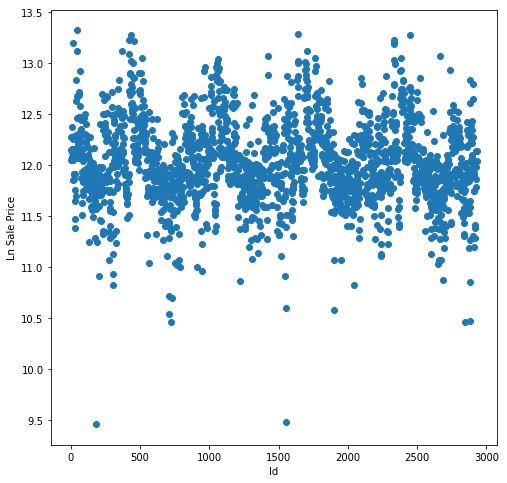

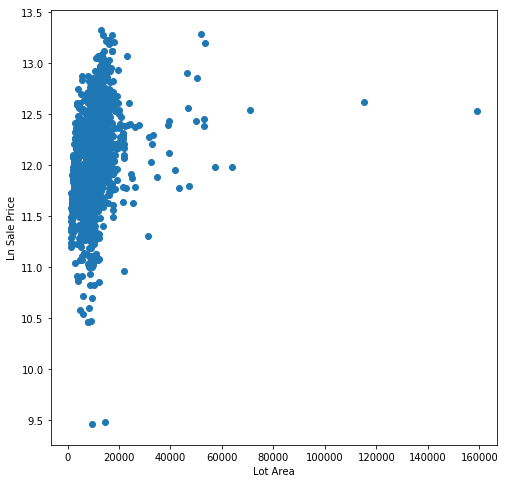

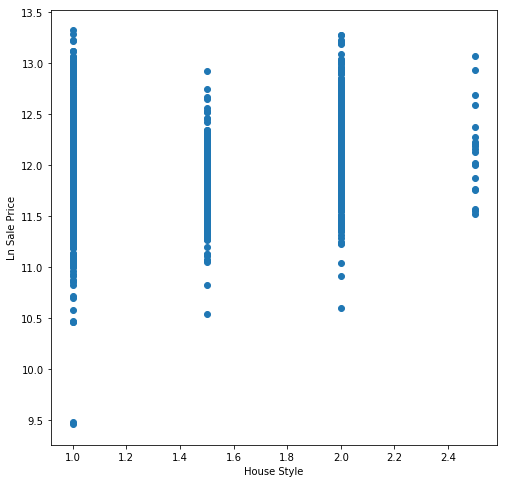

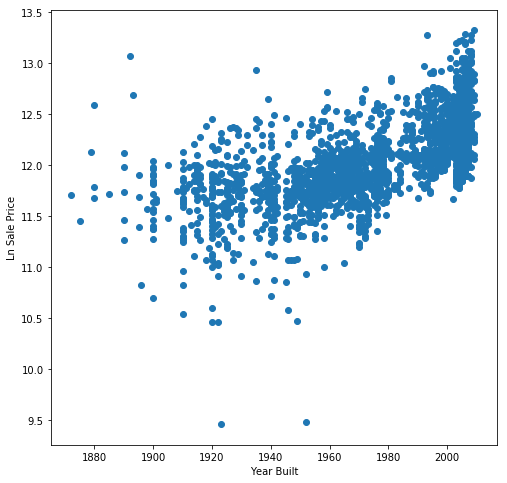

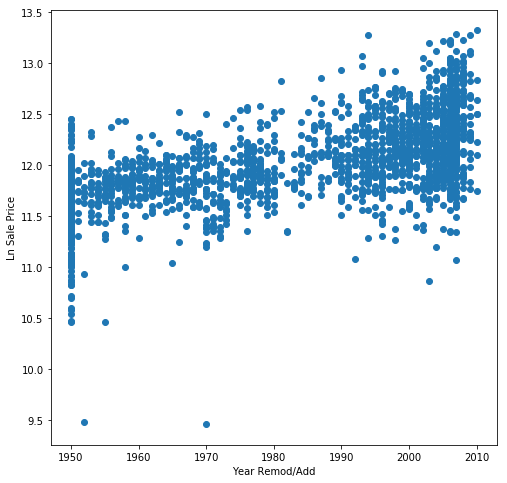

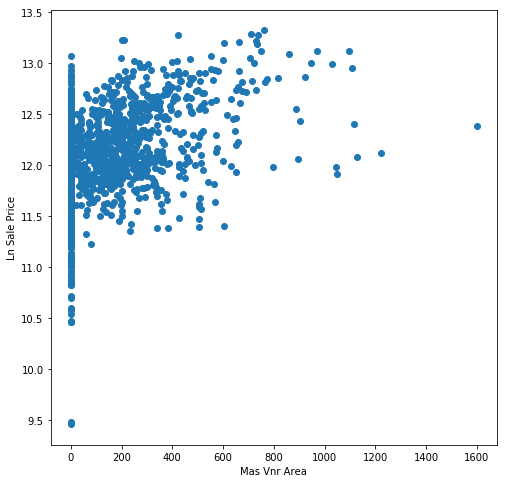

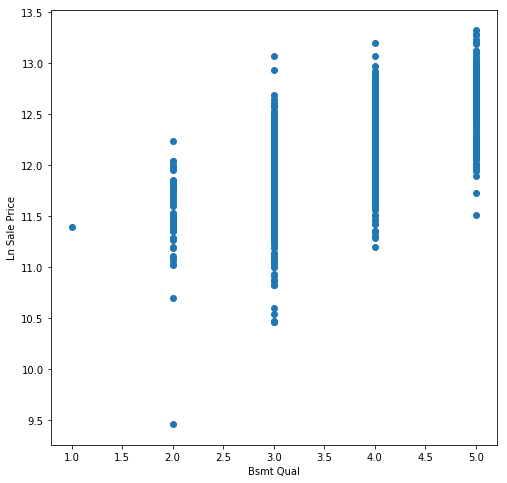

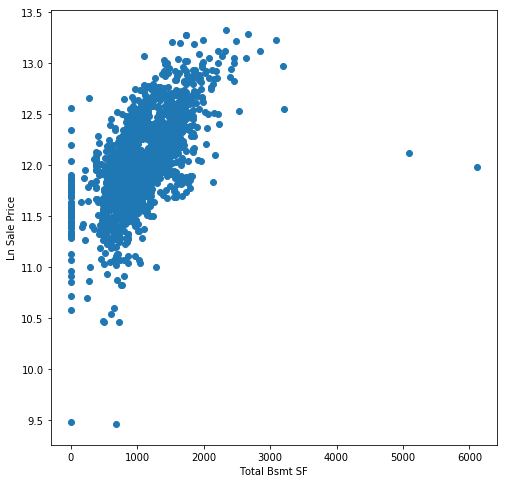

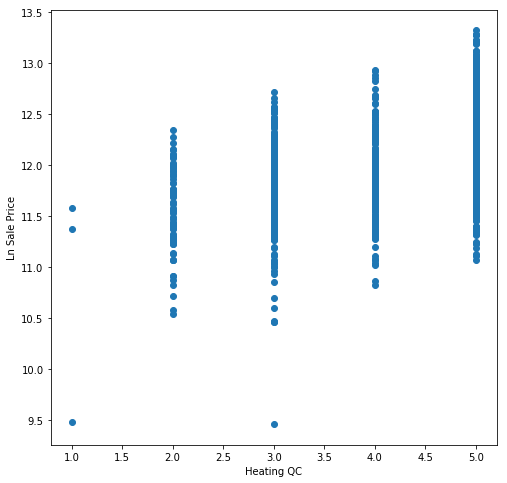

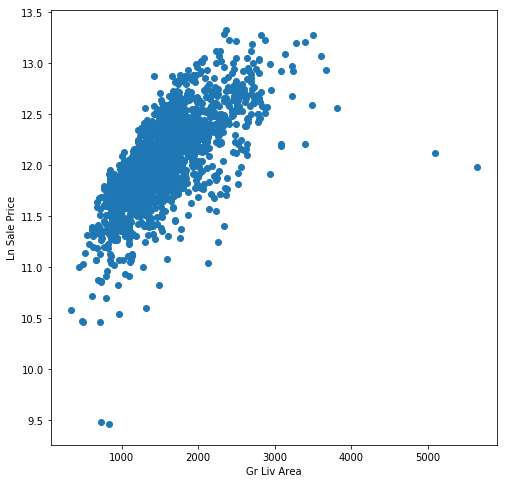

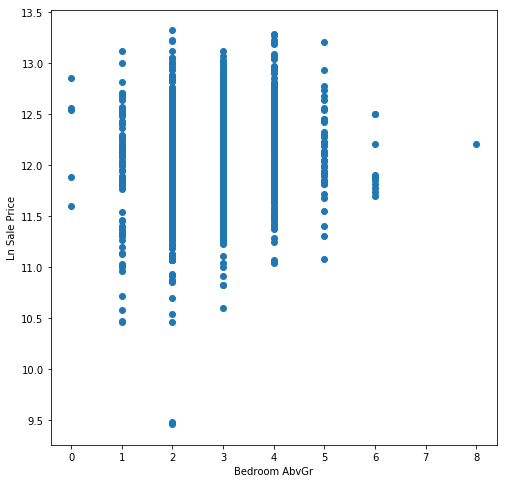

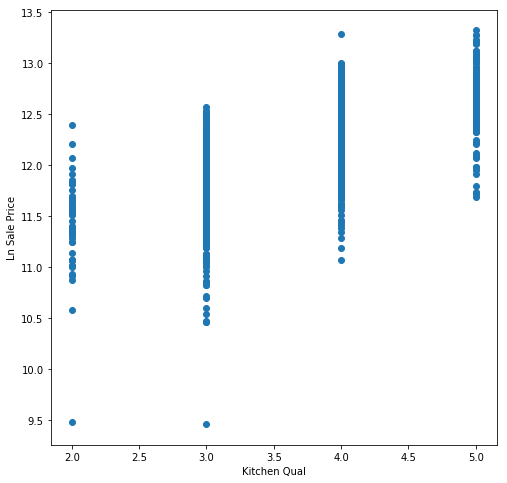

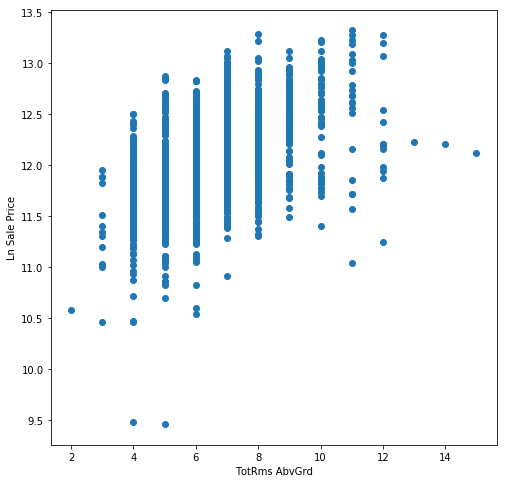

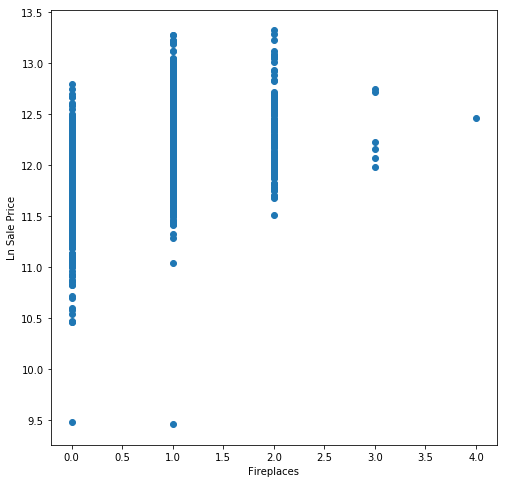

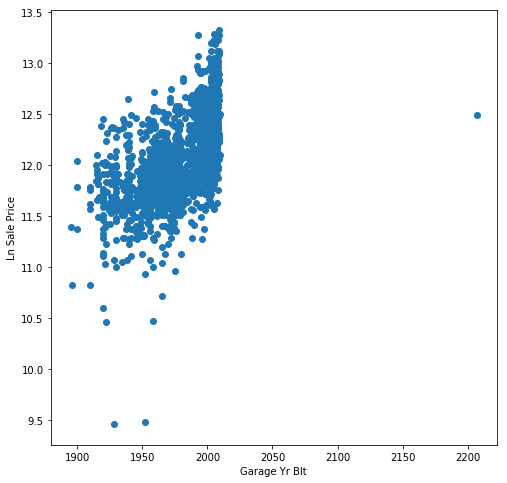

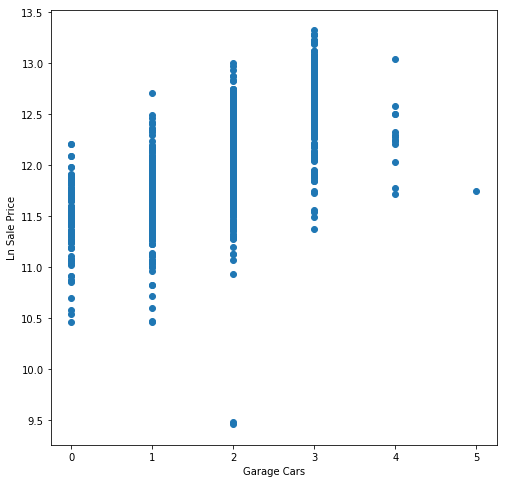

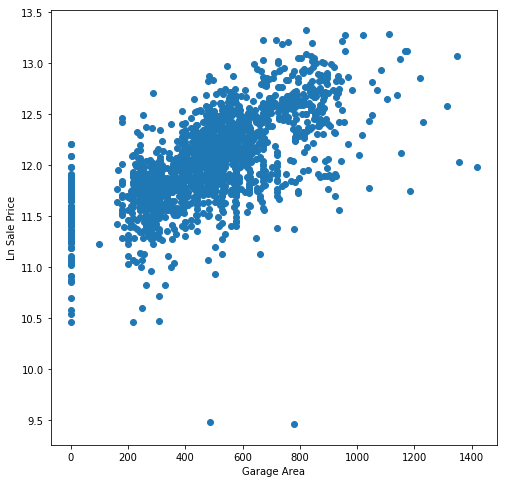

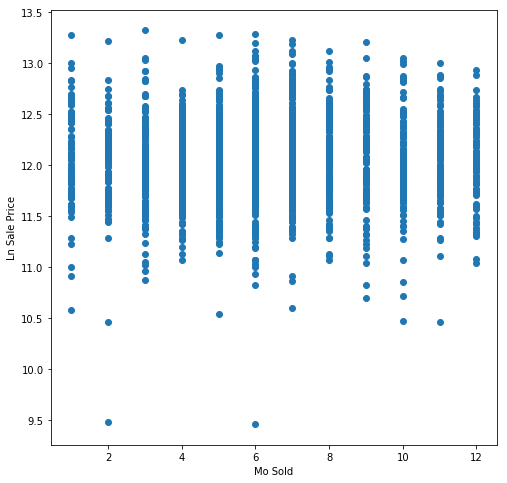

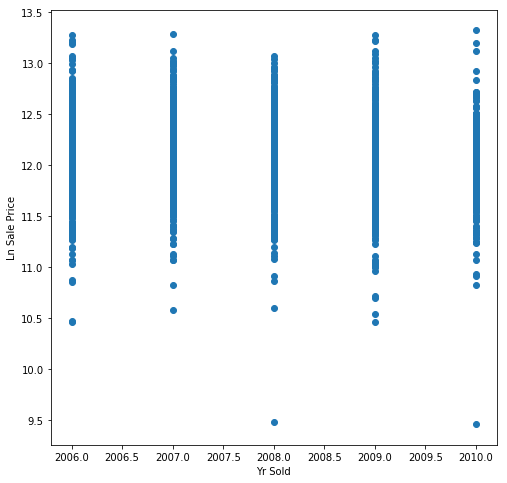

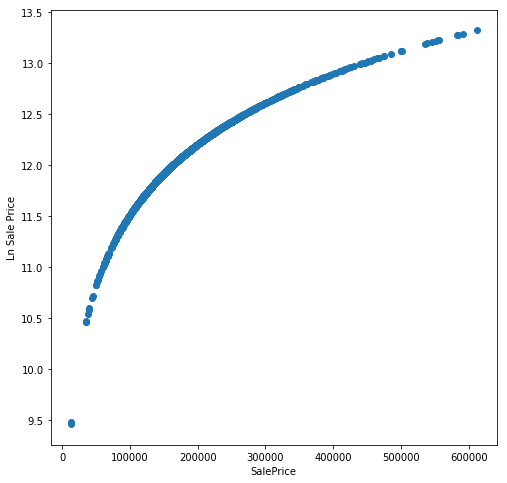

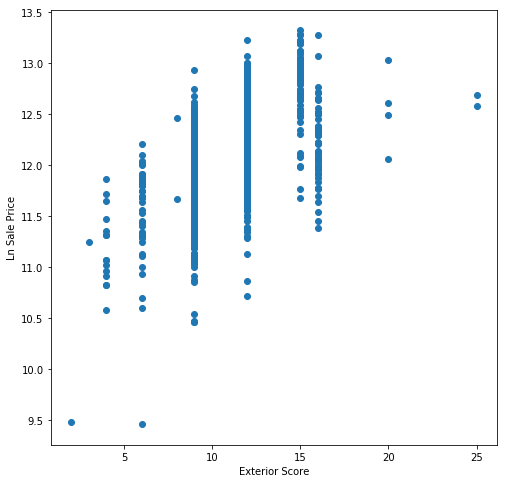

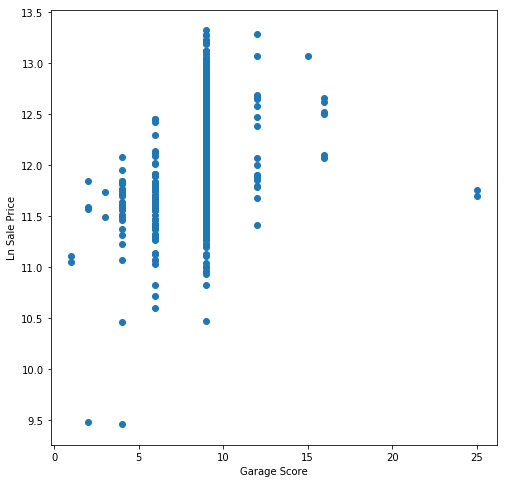

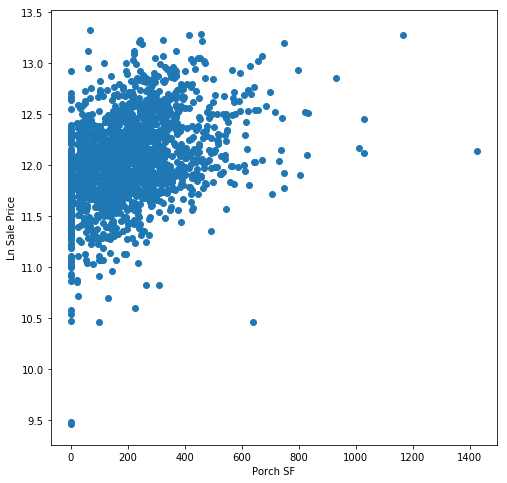

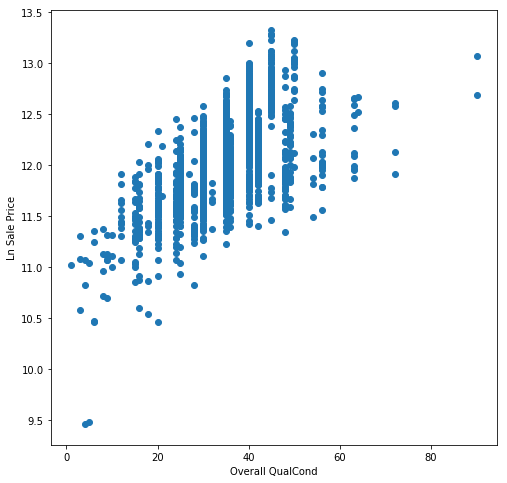

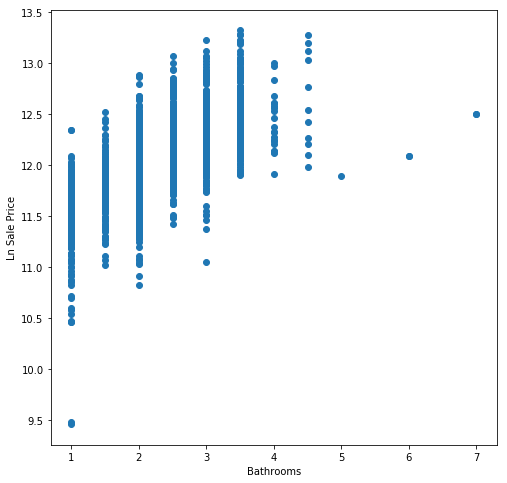

In [59]:
#Let's look at some scatterplots

for col in houses.select_dtypes(exclude = object).columns:
    plt.figure(figsize=(8,8))
    plt.scatter(houses[col].values, np.log(houses['SalePrice'].values))
    plt.xlabel(col)
    plt.ylabel('Ln Sale Price')

In [65]:
houses_numeric = houses[houses.select_dtypes(exclude = object).columns]

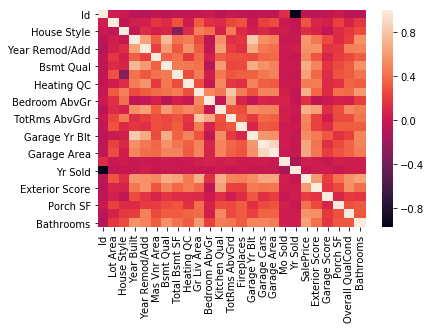

In [130]:
sns.heatmap(houses_numeric.corr())

In [132]:
#Correlations above 0.5 will go into features
for col in houses_numeric.columns:
    features = []
    if houses_numeric[col].corr(houses_numeric['SalePrice']) >= 0.5:
        features.append(col)
    print(features)

[]
[]
[]
['Year Built']
['Year Remod/Add']
['Mas Vnr Area']
['Bsmt Qual']
['Total Bsmt SF']
[]
['Gr Liv Area']
[]
['Kitchen Qual']
['TotRms AbvGrd']
[]
['Garage Yr Blt']
['Garage Cars']
['Garage Area']
[]
[]
['SalePrice']
['Exterior Score']
[]
[]
['Overall QualCond']
['Bathrooms']


In [79]:
features = ['Year Built', 'Year Remod/Add', 'Mas Vnr Area', 
            'Bsmt Qual', 'Total Bsmt SF', 'Gr Liv Area', 
            'Kitchen Qual', 'TotRms AbvGrd', 'Garage Yr Blt', 
            'Garage Cars', 'Garage Area', 'Exterior Score', 
            'Overall QualCond', 'Bathrooms']

In [80]:
#We will fill null values with the mean of the column:
feature_houses = houses[features]
for col in features:
    feature_houses[col] = feature_houses[col].fillna(feature_houses[col].mean())

/Users/williammccarthy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [81]:
feature_holdout = holdout[features]
for col in features:
    feature_holdout[col] = feature_holdout[col].fillna(feature_holdout[col].mean())

/Users/williammccarthy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
#Now a linear regression

X = feature_houses
y = np.log(houses['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

linreg = LinearRegression()
scores = cross_val_score(linreg, X_train, y_train)
print(scores)
print(scores.mean())

[0.88043801 0.83088631 0.77831615]
0.8298801586918815


In [84]:
linreg.fit(X_train,y_train)
linreg.score(X_test, y_test)

0.8328043739612239

In [85]:
X_holdout = feature_holdout
y_preds = linreg.predict(X_holdout)

In [86]:
my_ids = holdout['Id']
df1 = pd.DataFrame()
df1['Id'] = my_ids
df1['SalePrice'] = np.exp(y_preds)
df1.set_index('Id', inplace=True)

In [87]:
df1.to_csv('./my_preds_1.csv')

In [88]:
#Now let's try Lasso and Ridge

ss = StandardScaler()
ss.fit_transform(X_train)
ss.transform(X_test)


r_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_model = ridge_model.fit(X_train, y_train)


l_alphas = np.arange(0.001, 0.15, 0.0025)
lasso_model = LassoCV(alphas=l_alphas, cv=5)
lasso_model = lasso_model.fit(X_train, y_train)

In [90]:
ridge_model.score(X_test, y_test)

0.832305892394138

In [91]:
lasso_model.score(X_test, y_test)

0.8324130048435163

In [93]:
X2_holdout = feature_holdout
y2_preds = ridge_model.predict(X2_holdout)

X3_holdout = feature_holdout
y3_preds = lasso_model.predict(X3_holdout)

my_ids = holdout['Id']
df2 = pd.DataFrame()
df2['Id'] = my_ids
df2['SalePrice'] = np.exp(y2_preds)
df2.set_index('Id', inplace=True)
df2.to_csv('./my_preds_2.csv')

my_ids = holdout['Id']
df3 = pd.DataFrame()
df3['Id'] = my_ids
df3['SalePrice'] = np.exp(y3_preds)
df3.set_index('Id', inplace=True)
df3.to_csv('./my_preds_3.csv')

In [94]:
#Bad scores, let's get some dummies

neighborhood_dummy = pd.get_dummies(houses['Neighborhood'], drop_first = True)

In [102]:
features_neighbor = feature_houses.join(neighborhood_dummy)

In [103]:
neighborhood_dummy_holdout = pd.get_dummies(holdout['Neighborhood'], drop_first = True)
features_neighbor_holdout = feature_holdout.join(neighborhood_dummy_holdout)

In [114]:
#There are two neighborhoods not in the holdout set. We will remove them from the set.
neighborhood_dummy.columns

Index(['Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR', 'Landmrk',
       'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge',
       'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst',
       'StoneBr', 'Timber', 'Veenker'],
      dtype='object')

In [115]:
neighborhood_dummy_holdout.columns

Index(['Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'Greens', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes',
       'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer',
       'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'],
      dtype='object')

In [118]:
features_neighbor[features_neighbor['GrnHill'] == 1]

,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Qual,Total Bsmt SF,Gr Liv Area,Kitchen Qual,TotRms AbvGrd,Garage Yr Blt,Garage Cars,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
463,1998,1998,239.0,4.000000,1502.0,1502,4,5,1998.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1211,1986,1986,0.0,3.586172,0.0,1295,4,5,1986.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
features_neighbor[features_neighbor['Landmrk'] == 1]

,Year Built,Year Remod/Add,Mas Vnr Area,Bsmt Qual,Total Bsmt SF,Gr Liv Area,Kitchen Qual,TotRms AbvGrd,Garage Yr Blt,Garage Cars,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
1121,1993,1994,0.0,4.0,630.0,1320,3,5,1993.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
#Drop rows 463, 1211, 1121 from test and holdout, then drop 'GrnHill' and 'Landmrk'

features_neighbor_holdout.drop('Landmrk', axis =1)

KeyError: "labels ['Landmrk'] not contained in axis"

In [104]:
X1 = features_neighbor
y1 = np.log(houses['SalePrice'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)

linreg1 = LinearRegression()
scores = cross_val_score(linreg1, X1_train, y1_train)
print(scores)
print(scores.mean())

[0.83040805 0.84876932 0.84669582]
0.8419577281937798


In [105]:
linreg1.fit(X1_train,y1_train)
linreg1.score(X1_test, y1_test)

0.8982324441411801

In [128]:
linreg1.predict(features_neighbor_holdout)

ValueError: shapes (879,39) and (41,) not aligned: 39 (dim 1) != 41 (dim 0)